# The hidden cut algorithm for locating unentanglement

One of the most interesting and counterintuitive features of quantum physics is entanglement.
Entanglement is a form of correlation between quantum systems that is fundamentally different from any correlation that can exist between classical systems.
To define entanglement, let $\ket{\psi}$ be a state of a quantum system with two parts, $A$ and $B$.
For example $A$ and $B$ might each be single qubits; then $\ket{\psi}$ is a two qubit state.
We say $A$ and $B$ are *unentangled* or *separable* if $\ket{\psi}$ can be written as a tensor product
$$
\ket{\psi} = \ket{\psi_A}\otimes \ket{\psi_B}
$$,
where $\ket{\psi_A}$ is a state of system $A$ and $\ket{\psi_B}$ is a state of system $B$.
If $\ket{\psi}$ isn't separable then we say $A$ and $B$ are *entangled*.

Now suppose we're given a state of $n$ qubits.
We're told that it's possible to split the qubits into two unentangled subsets, $S$ and $\bar S$, 
in other words $\ket{\psi}$ can be written as
$$
\ket{\psi} = \ket{\psi_S}\otimes \ket{\psi_{\bar S}},
$$
but we aren't told what $S$ and $\bar S$ are.  
Question: how can we determine $S$ and $\bar S$, or in other words, how do we determine the ``hidden cut'' that splits the qubits into two unentangled subsystems.
Following ..., in this demo we'll develop a quantum algorithm that solves this problem!

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from scipy.stats import unitary_group

# set random seed
np.random.seed(hash('hidden_cut') % 2**32)

## Creating a separable state

Let's create a separable state with $n=5$ qubits.
First we define a function that creates a random state with a specified number of qubits.
We do this by creating a $2^n$ by $2^n$ random unitary and taking the first row.
Because all the rows (and columns) in a unitary matrix have norm equal to 1, this defines a valid quantum state.

In [38]:
def random_state(n_qubits):
    dim = 2**n_qubits
    return unitary_group.rvs(dim)[0]

We'll use this function to set qubits $S=\{0,3\}$ and $\bar S=\{1,2,4\}$ to each be in a random pure state.
The full 5 qubit state will then be separable along this partition. 

In [39]:
def separable_state(partitions):
    # Number of qubits
    n_qubits = sum(len(part) for part in partitions)

    # Sort partitions
    partitions = [sorted(part) for part in partitions]

    # Create random state for each partition
    partition_states = [(part, random_state(len(part))) for part in partitions]
    
    # Initialize full state
    full_state = np.zeros(2**n_qubits, dtype=complex)
    
    # Fill in amplitudes
    for idx in range(2**n_qubits):
        # Convert idx to binary string
        bits = format(idx, f'0{n_qubits}b')
        
        # Calculate amplitude as product of partition amplitudes
        amplitude = 1.0
        for part, state in partition_states:
            # Extract partition bits, convert to decimal, update amplitude
            part_bits = ''.join(bits[q] for q in part)
            part_idx = int(part_bits, 2)
            amplitude *= state[part_idx]
        
        full_state[idx] = amplitude
    
    return full_state

# create separable 5 qubit state
S = [0,3]
S_bar = [1,2,4]
state = separable_state([S, S_bar])
n = int(np.log2(len(state)))
print(f'Created {n} qubit state with qubits {S} unentangled from {S_bar}.')

Created 5 qubit state with qubits [0, 3] unentangled from [1, 2, 4].


## Subsystem purities

Let's verify that qubits $S=\{0,3\}$ are unentangled with qubits $\bar S=\{1,2,4\}$.
One way to check if a subsystem $S$ of a pure state $\ket{\psi}$ is entangled with the complementary subsystem $\bar S$
is to consider the reduced density matrix $\rho_S$ describing the state of $S$ and compute its purity, 
$$
P(S) := \text{Tr}(\rho_S^2).
$$
If $S$ and $\bar S$ are unentangled, i.e. $\ket{\psi} = \ket{\psi_S}\otimes \ket{\psi_{\bar S}}$, then $\rho_S = \ket{\psi_S}\bra{\psi_S}$
and the purity of $S$ is $P(S)=1$.
Meanwhile if $S$ and $\bar S$ *are* entangled, then $\rho_S$ will be a mixed state and $P(S)$ will be less than 1
(can you prove this?).

So to verify that qubits $S=\{0,3\}$ are unentangled with qubits $\bar S=\{1,2,4\}$ we just need to check that $P(S) = 1$. 
Instead of just computing $P(\{0,3\})$, let's go a step further and compute the purities of *all* subsystems of qubits.
Because there are 5 qubits we can denote a subsystem as a 5-bit string, where a 1 bit indicates that a qubit belongs to the subsystem and a 0 bit that it doesn't belong.
For example '10010' denotes the subsystem $S=\{0,3\}$ because it has 1s in positions 0 and 3.

Since there are $2^5=32$ different 5-bit strings, there are 32 total subsystems.
Let's create a histogram showing all 32 subsystem purities.
First we define a function to compute the purity of a subsystem.
`qml.purity()` does the heavy lifting:

In [40]:
dev = qml.device('default.qubit')

@qml.qnode(dev)
def get_purity(state, subsystem):
    qml.StatePrep(state, wires=range(n))
    return qml.purity(wires=np.nonzero(subsystem)[0])

Now let's compute all subsystem purities and store them in a `purities` list.
We'll also store the subsystems, encoded as 5-bit strings, into a `bitstrings` list.
The empty subsystem 00000 is an edge case that `qml.purity()` can't handle, so we add it by hand.
Because complementary subsystems have identical purities (prove this!), $P(00000) = P(11111) = 1$.

In [41]:
bitstrings = ['0' * 5]
purities = [1.]

for subsystem_idx in range(1, 2**n):
    # convert integer index to list of bits
    subsystem = [int(bit) for bit in format(subsystem_idx, f'0{n}b')]
    
    # compute purity and append
    purity = get_purity(state, subsystem)
    purities.append(purity)

    # convert bit list to bit string and append
    bitstring = ''.join(str(bit) for bit in subsystem)
    bitstrings.append(bitstring)

Now we can plot the purities in a histogram

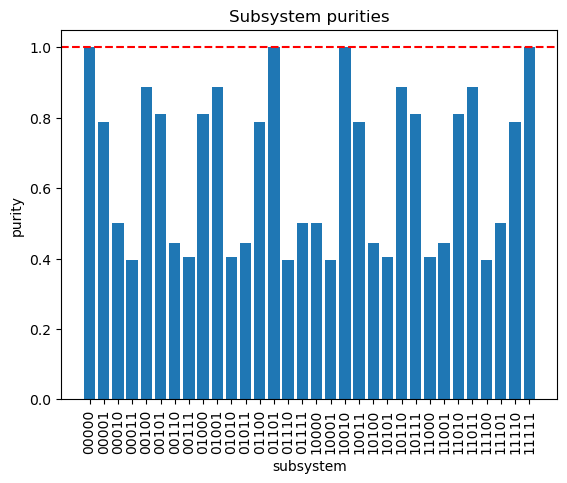

In [42]:
plt.bar(bitstrings, purities)
plt.xticks(rotation=90)
plt.axhline(y=1.0, color='r', ls='--')
plt.xlabel('subsystem')
plt.ylabel('purity')
plt.title('Subsystem purities')
plt.show()

Notice the 4 subsystems that have purity equal to 1: 
- the entire system 11111 and its empty complement 00000
- the subsystem 10010 and its complement 01101

Remember that a purity of 1 means that the subsystem is pure.
This tells us that besides the entire state $\ket{\psi}$ and the trivial empty state, which are pure by definition,
the only other subsystems that are pure are $S=\{0,3\}$ (encoded as '10010') and $\bar S=\{1,2,4\}$ (encoded as '01101').
So $\ket{\psi}$ is separable along the cut between $S$ and $\bar S$, exactly as we expected.

## The naive approach to hidden cuts

Remember our problem: given a state of many qubits, find the separable components.

The above discussion suggests one way to solve the problem: 
compute the purities of all subsystems and look for the subsystems with purity equal to 1.
The problem with this approach is that a system of $n$ qubits has $2^n$ subsystems, 
so looking for pure subsystems by brute force search has an exponential complexity in $n$.

We need a more efficient way to find the hidden cut.

## Symmetries of the purity function

Let's look at the subsystem purity function (the historgram we plotted above) more closely.
Notice that some of the bars seem like they're the same height.
To visualize this, let's colour in the bars according to their height:

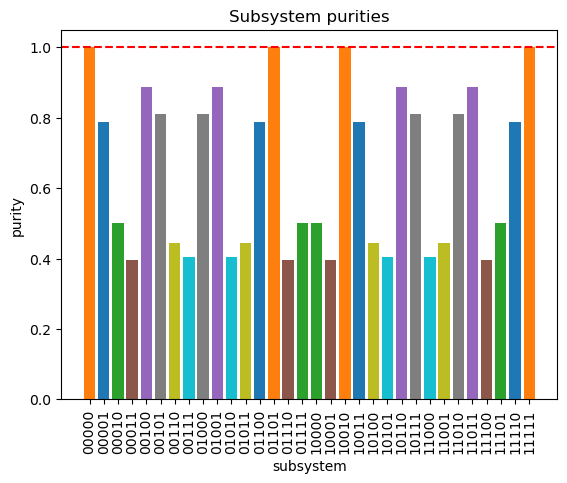

In [43]:
# colour map
cmap = plt.cm.tab10
purities = np.round(purities, 5)
unique_purities = set(purities)
colours = cmap(np.linspace(0, 1, len(unique_purities)))
purity_to_colour = dict(zip(unique_purities, colours))
bar_colours = [purity_to_colour[purity] for purity in purities]

# plot
plt.bar(bitstrings, purities, color=bar_colours)
plt.xticks(rotation=90)
plt.axhline(y=1.0, color='r', ls='--')
plt.xlabel('subsystem')
plt.ylabel('purity')
plt.title('Subsystem purities')
plt.show()

Notice that there are 8 sets of 4 bitstrings each with the same purity.  
**Question**: How are bitstrings of the same purity related? 

Pause here for a bit, stare at the histogram, and try to answer the question yourself! 

Ready for the answer?

**Answer**: Same purity bitstrings are related by bitstring addition of 01101 and 10010.

For example, start with the first orange bar, 00000.
- Adding 01101 to 00000 gives 01101, the second orange bar. 
- Adding 10010 to 00000 gives 10010, the third orange bar.
- Adding both 01101 and 10010 to 00000 gives 11111, the fourth orange bar.

These four orange bars are the subsystems of purity 1 that we discussed earlier.

As another example, start with the third violet bar, 10110.
- Adding 01101 (bitwise modulo 2) to 10110 gives 11011, the fourth violet bar.
- Adding 10010 to 10110 gives 00100, the first violet bar.
- Adding both 01101 and 10010 to 10110 gives 01001, the second violet bar.


In fact, this approach to getting bars of the same height always works.
You should try it by starting with a bar of another colour.
You'll find that adding 01101 and/or 10010 to this bar will always give the other 3 bars of the same colour!

What this observation tells us is that the purity function $P(s)$ has a symmetry: 
For any bitstring $s$,
$$
P(s) = P(s + 10010) = P(s + 01101) = P(s + 11111)
$$
We can associate the set $H = \{00000, 10010, 01101, 11111\}$ to our symmetry;
these are the bitstrings that we can add to $s$ without changing its purity.
The set $H$ has three important properties:
1. It contains the unique "identity" bitstring 00000, for which $s + 00000 = s$ for all $s$
2. The set is closed under addition
3. Every element in $H$ has an inverse in $H$, such that the element plus its inverse give the identity. 
(In fact every element is its own inverse.)

These three properties turn $H$ into what is called a *group* in math.
A group is just a set closed under an associative "addition" operation (here bitstring addition), containing an identity and inverses for every element.
So what we discovered is that the purity function has a symmetry and that this symmetry is associated with a group.
Thinking of symmetries as groups is arguably the most successful guiding principle in quantum physics (if not all of physics), and we'll see that it's useful here as well.

## Hidden cut problem as a hidden subgroup problem

To see how symmetries can help us find separable components, take another look at the symmetry group $H$.
Notice that by adding the two bitstrings 10100 and 01011 in different linear combinations, we can generate any element of $H$. 
We say that 10010 and 01101 are "generators" of $H$.

**Question**: Is there anything special about the generators 10010 and 01101 of the symmetry group $H$?

Pause and think about it!

**Answer**: The generators directly give us the separable subsets $S$ and $\bar S$ of the original 5-qubit state! 
What I mean is that the first generator 10010 has 1s in positions 0 and 3, so this gives the subset $S=\{0,3\}, 
and the second generator 01101 has 1s in positions 1, 2, and 4, so this gives the complementary subset $S=\{1,2,4\}$.

In fact, this relationship between generators and separable components is not a coincidence:
for any multi-qubit state $\ket\psi$ the separable components are equal to the generators of $H$, the symmetry group of the purity function!
(Optional exercise for curious readers: prove this statement!)


<!-- To see why, let's work through an example using our state $\ket\psi = \ket{\psi_{0,2}}\otimes\ket{\psi_{1,3,4}}$.
We can schematically visualize this state as:

[Picture: graph with nodes 0,2 connected and nodes 1,3,4 connected]

As an example let's consider subsystem $A=01110$ containing qubits 1, 2, and 3.
We can shade in the qubits corresponding to subsystem $A$:

[Picture: same graph but now with nodes 1,2,3 shaded in]

Because qubit 2 is separated from qubits 1 and 3, the density matrix of subsystem $A$ is $\rho_A = \rho_{\{1,3\}}\otimes\rho_{\{2\}}$.
Using the property that the trace of a tensor product of matrices is the product of traces, the purity of $A$ becomes:
$$
P(A) = 
\text{Tr}(\rho_{\{1,3\}}^2)
\text{Tr}(\rho_{\{2\}}^2).
$$

Ok, now let's look at subsystem $B$ obtained by adding to $A$ the bitstring $10100$, corresponding to the separable component $\bar S = \{0,2\}$. 
Bitstring addition gives $B = 11010$, the subsystem containing qubits 0, 1, and 3.
Because we added the bitstring corresponding to $\bar S = \{0,2\}$, this just toggles the shading on those bits:

[Picture: same graph but now with nodes 0,1,3 shaded in]

The density matrix of subsystem $B$ is $\rho_B = \rho_{\{1,3\}}\otimes\rho_{\{0\}}$ and the purity of $B$ is:
$$
P(B) = 
\text{Tr}(\rho_{\{1,3\}}^2)
\text{Tr}(\rho_{\{0\}}^2).
$$
So the only difference between $P(A)$ and $P(B)$ is that the factor $\text{Tr}(\rho_{\{2\}}^2)$ got replaced by the factor $\text{Tr}(\rho_{\{0\}}^2)$.
This corresponds to the "toggling" of the bits in $\bar S=\{0,2\}$.
But because $\bar S$ is a separable system $\text{Tr}(\rho_{\{2\}}^2)$ is equal to $\text{Tr}(\rho_{\{0\}}^2)$, and so $P(A) = P(B)$!
The general point is: toggling bits in a separable component doesn't change the purity.
Or in other words: separable components are symmetry generators of the purity function. -->

This is a very important observation!
It means that to determine the separable components of $\ket\psi$ we just need to find $H$, the symmetry group of the purity function!




Just as the bitstrings $H = \{00000, 10100, 01011, 11111\}$ form group, the set $G$ of all $n$-bit strings also forms a group: 
it's closed under addition, it contains the identity, and every element in $G$ has an inverse in $G$.
$G$ contains $2^n$ elements.
In fact, the group $H$ is a subset of the group $G$.
We say that $H$ is a *subgroup* of $G$.
Because the generators of $H$ encode the separable components of $\ket\psi$, we can find the hidden cut of $\ket\psi$ by finding the hidden subgroup $H$ of $G$.
This is an example of a *hidden subgroup problem* (HSP), an important class of problems that quantum computers can solve efficiently. 
The most famous HSP is the problem of factoring large integers.
Like the hidden cut problem, it's not immediately obvious that factoring is related to finding a subgroup, but in fact it is.
We'll use the HSP algorithm to solve the hidden cut problem.

In the general HSP we want to find the symmetry subgroup $H$ of a function $f$ over a group $G$. 
When $G$ is the group of $n$-bit strings, the algorithm to solve the HSP is particularly simple.
The algorithm assumes that we have access to a quantum version of the function $f$, meaning a unitary $U_f$
that maps $\ket g \ket 0$ to $\ket g \ket{f(g)}$ for every element $g$ of the group $G$.
Here $\ket g$ is an encoding of $g$ into an $n$-qubit register, and $\ket{f(g)}$ is a second register that encodes $f(g)$ such that
$\ket{f(g)}$ and $\ket{f(g')}$ are equal if $f(g) = f(g')$ and otherwise orthogonal.

The HSP algorithm works by obtaining measurements from a quantum circuit and then postprocessing the measurements.
The quantum circuit first applies Hadamards to the $\ket 0$ state to create a uniform superposition $\sum_g \ket g$ in the group register, 
then applies $U_f$ to create the state $\sum_g \ket g\ket{f(g)}$, and finally again applies Hadamards to the first register.
The circuit looks like:

[Picture of circuit]

The key feature of this circuit is that measurments of the group register are guaranteed to be orthogonal to the hidden subgroup $H$.
For example if we run the circuit and get a measurement outcome $m=10101$, then we know that $a = 00011$ is not in $H$ because $a\cdot m != 0 \text{ mod }2$.
Repeatedly running the circuit and performing measurements tells us what bitstrings cannot be in $H$.
After $\mathcal O(n)$ measurements, the bitstrings that are orthogonal to all measurements are very likely in $H$.
At this point we stop the algorithm and predict that $H$ is given by these bitstrings.

Now let's apply this to solve the hidden cut problem for the state $\ket \psi$.
The general function $f(s)$ is now the subsystem purity function $P(s)$.


In [44]:
# Suppose we want to find the hidden symmetry subgroup of a function f(s) over n-bit strings s. we start with two n-qubit registers initialized in the all |0> states. 
# the first step is to apply a Hadamard to each qubit in the first register to create a uniform superposition sum |s>.
# the second step assumes that we have access to a unitary U_f that maps |s>|0> to |s>|f(s)>, such that |f(s)> and |f(s')> are equal if f(s) = f(s') and orthogonal if f(s) != f(s').
# the final step is to again apply Hadamards to the first register, and measure this register.
# the circuit looks like:

# The crucial feature of this circuit is that the measurement outcomes are guaranteed to be orthogonal to the hidden subgroup bitstrings (ie the bitstrings defining the symmetry of f(s)).
# for example if we get a measurement outcome ..., then a hidden subgroup element might be ... because ..., but ... is definitely not in the hidden subgroup, because ....
# Therefore by obtaining measurment outcomes and finding the bitstrings orthogonal to all measurments, we will identify the hidden symmetry of f.

# Now let's apply this to solve the hidden cut problem for the state psi. Remember that here the function f(s) is pi(s), the purity of psi's subsystems.
# We immediately run into a problem however. Unlike in the basic HSP problem, we arent provided with a unitary mapping |s>|0> to |s>|pi(s)>.
# So what do we do? Let's create the unitary!

# Recall the key property that the unitary is supposed to have: |f(s)> and |f(s')> should be equal if f(s) = f(s') and orthogonal if f(s) != f(s').
# Consider the controlled swap unitary, mapping |s>|psi>|psi> to |s>SWAP_s(|psi>|psi>), where s denotes the qubits to be swapped between the two copies of |psi>

# Let's check if the controlled swap unitary has the desired properties.
# First, if pi(s) = pi(s') we want SWAP_s(|psi>|psi>) to equal SWAP_s(|psi>|psi>). 
# Let's consider an example. We see from our plot of pi(s) that ... and ... have the same value of pi.
# Let's check the inner product of SWAP_s(|psi>|psi>) and SWAP_s'(|psi>|psi>):

# Since the inner product is 1, the SWAP_s(|psi>|psi>) and SWAP_s'(|psi>|psi>) must be identical.

# Now let's check whether pi(s) != pi(s') implies SWAP_s(|psi>|psi>) and SWAP_s'(|psi>|psi>)...

# So it turns out that SWAP_s(|psi>|psi>) and SWAP_s'(|psi>|psi>) are not orthogonal and so the SWAP_s unitary does not satisfy the second requirement for the unitary in the HSP circuit.

# Even though we don't expect it to work, let's nevertheless try running the HSP circuit with the SWAP_s unitary, and see what happens.

# ...10 samples

# Remember the final postprocessing step to solving an HSP via a quantum computer: we have to determine the bitstrings orthogonal to the measurement outcomes, where two bitstrings s and t are orthogonal if s.t = 0 modulo 2. This is a basic linear algebra problem that amounts to finding the nullspace of the matrix of measurement outcomes over the finite field GF(2).

# But by being clever we can avoid doing any linear algebra.

# Look at the allowed measurement outcomes very carefully. Do you notice anything in common between them?

# The answer: they are exactly those bitstrings that have an even number of 1s in positions ... *and* an even number of 1s in positions ...

# This means that the only bitstrings orthogonal to the allowed measurement outcomes are the all 0 bitstring, the all 1 bitstring, the bitstring ... and the bitstring ...

# This is exactly the hidden subgroup generated by ... and ..., where the generators encode the separable components ... and ... of the original state |psi>.

# Therefore the HSP circuit with the SWAP_s unitary finds the separable components!

# Let's check it with another state to make sure we didn't just get lucky.

# This time let's consider a 4 qubit state ...


# again it works!

# So we have solved the hidden cut problem by rephrasing it as an HSP and using the unitary SWAP_s.

# but why does this work? Recall that in the standard quantum circuit for HSP we need |f(s)> and |f(s')> should be equal if f(s) = f(s') and orthogonal if f(s) != f(s'). However in our case f(s) is the purity function pi(s), and we set |pi(s)> = SWAP_s(|psi>|psi>). We saw above that this satisfies the equality requirement, but not the orthogonality requirement. Namely pi(s) != pi(s') doesn't generally imply that |pi(s)> and |pi(s')> are orthogonal.

# To understand why our circuit worked despite this non-orthogonality, let's think about how we could have defined |pi(s)> differently so that the orthogonality requirement *was* satisfied.
# This is actually quite straightforward: just define |pi(s)> = [SWAP_s(|psi>|psi>)]^t for some large t. 
# Then as long as the inner product between SWAP_s(|psi>|psi>) and SWAP_s(|psi>|psi>) is not 1 (ie they aren't identical), the inner product between |pi(s)> and |pi(s')> will be effectively 0 (exponentially approach 0 as t increases).

# So if instead of using only 1 pair |psi>|psi> in our quantum circuit we used t pairs, for large enough t this would've exactly functioned like a standard issue HSP circuit.

# Unfortunately the circuit with t pairs of |psi>|psi> requires (1 + 2t) * n qubits (the 1 is for the control register and the 2t for the 2t pairs of |psi>|psi>), so simulating this with n=4 is not feasible for t > 2.

# With that in mind let's look consider the circuit with t=2 and compare with what we got above with t=1. Hopefully we'll see something interesting that we can extrapolate to t -> inf.

# ...

# plot probs histograms

# we notice that the same measurement outcomes are allowed, and only their probabilities differ.

# in particular the distribution is more skewed towards outcomes with fewer 1s for t=1, and more uniform for t=2

# we can conjecture that this trend continues for larger t: the allowed outcomes remain the same as in the t=1 case, but the distribution becomes more and more uniform.

# in fact this it can be proven analytically that this conjecture is correct, and if we had a powerful enough simulator (or a quantum computer), we'd be able to verify this.

# So now we can understand why our hidden cut circuit with only 1 pair of |psi>s worked, when naively we didn't expect it to. It is because the allowed measurement outcomes from the output of this t=1 circuit are exactly the allowed measurmenet outcomes from the t-> infty circuit. Because the outcome of the final postprocessing step of the quantum HSP algorithm only depends on the allowed measurement outcomes and not on their probabilities, the t=1 algorithm is able to get the same outcome as the large t algorithm. 

# So should we use small t or large t?

# do sample efficiency experiment. Expect result to be: use large t if you can because it's more sample efficient. 



In [45]:

def hidden_cut_circuit(state, n_copies=1):

    n = int(np.log2(len(state)))
    n_qubits = (2 * n_copies + 1) * n
    dev = qml.device('lightning.qubit', wires=n_qubits)

    @qml.qnode(dev)
    def _circuit():
        # Create copies of state
        for pair in range(n_copies):
            for copy in range(2):
                offset = n + 2 * n * pair + n * copy
                qml.StatePrep(state, wires=range(offset, offset + n))
                                
        # Hadamard transform
        for wire in range(n):
            qml.Hadamard(wires=wire)

        # Controlled swaps
        for c in range(n):
            for pair in range(n_copies):
                a = c + n + 2*n*pair
                b = c + n + 2*n*pair + n
                qml.ctrl(qml.SWAP, c, control_values=1)(wires=(a,b))

        # Hadamard transform
        for wire in range(0, n):
            qml.Hadamard(wires=wire)

        # Return probs of first register
        return qml.probs(wires=range(n))

    return _circuit()
    
probs = hidden_cut_circuit(state, n_copies=1)
bitstrings = [bin(x)[2:].zfill(n) for x in range(2**n)]

# plt.bar(bitstrings, probs)
# plt.xticks(rotation=90)
# plt.show()

# np.random.choice(len(probs), size=100, p=probs)

In [46]:
dev = qml.device('lightning.qubit', shots=10, wires=[0])
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    qml.Snapshot('tag', qml.state())
    # return qml.state()
    return qml.probs()

qml.snapshots(circuit)()

DeviceError: Measurement state(wires=[]) not accepted with finite shots on lightning.qubit